# Alternative time series

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv("/workspaces/Alt_time_series/data/raw/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


Transformar los datos temporales

In [22]:
print(df['date'].dtype)

object


Hay que asegurarse que los datos se muestren en formato datetime64

In [23]:
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)  

datetime64[ns]


### Representamos gráficamente

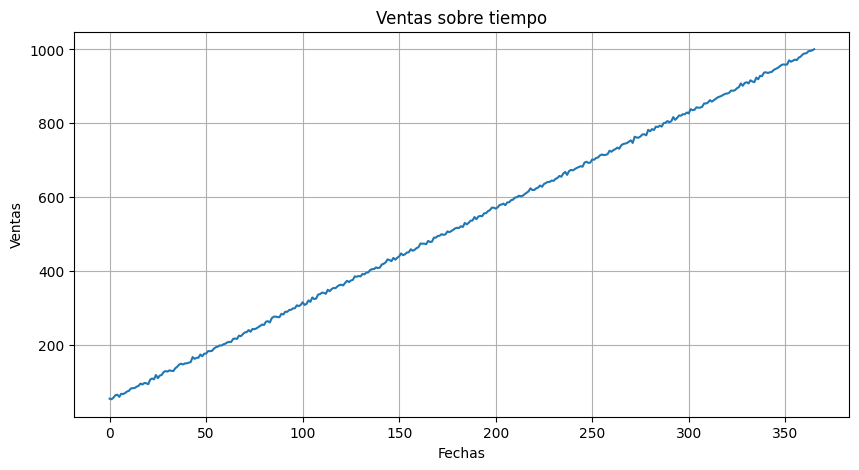

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['sales'])
plt.title('Ventas sobre tiempo')
plt.xlabel('Fechas')
plt.ylabel('Ventas')
plt.grid()
plt.show()

Comprobar la tendencia. Para ello vamos a calcular la media de los tres períodos anteriores (incluyendo el actual) con la funcion rolling y guardamos los valores resultantes en una nueva columna que llamaremos "media_movil". La media se muestra por encima de los valores que hemos visto antes con una linea roja. He usado un marcador en estrella para que sea mas visual.

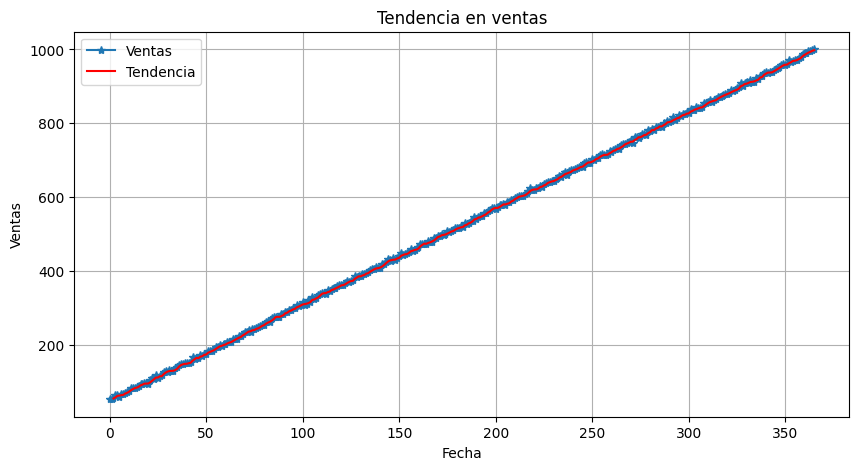

In [25]:
df['media_movil'] = df['sales'].rolling(window=3).mean()
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['sales'], label='Ventas',marker='*')
plt.plot(df.index, df['media_movil'], label='Tendencia', color='red')
plt.title('Tendencia en ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid()
plt.show()

Seasonality

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

df.set_index('date', inplace=True)  

decomposition = seasonal_decompose(df['sales'], model='additive') 


KeyError: "None of ['date'] are in the columns"

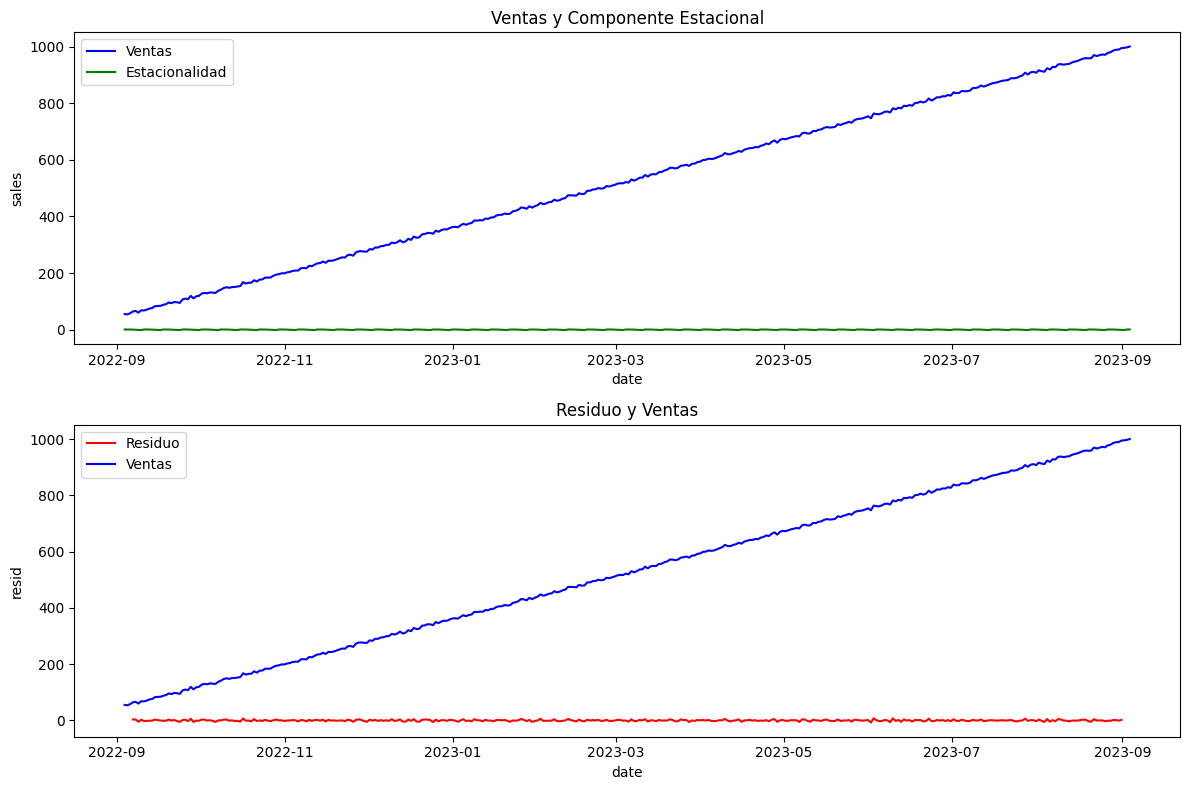

In [36]:
seasonal = decomposition.seasonal
resid=  decomposition.resid
plt.figure(figsize=(12, 8))


plt.subplot(211)
sns.lineplot(data=df['sales'], label='Ventas', color='blue')
sns.lineplot(data=seasonal, label='Estacionalidad', color='green')
plt.title('Ventas y Componente Estacional')
plt.legend()


plt.subplot(212)
sns.lineplot(data=resid, label='Residuo', color='red')
sns.lineplot(data=df['sales'], label='Ventas', color='blue')  
plt.title('Residuo y Ventas')
plt.legend()

plt.tight_layout()
plt.show()

Datos estacionarios o no:  (Test de Dickey-Fuller)

In [43]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
        print(f"Valor crítico {key}: {value:.4f}")

ADF Statistic: 0.545414193706378
p-value: 0.9861899815311064
Valor crítico 1%: -3.4491
Valor crítico 5%: -2.8698
Valor crítico 10%: -2.5712


Dado que el ADF excede con creces por encima de 0.05 no podemos rechazar la hipótesis nula. No podemos afirmar que la serie de tiempo es estacionaria, por lo que determinamos que es "no estacionaria". 

Con respecto a los valores críticos, ninguno de ellos es mayor a la estadística ADF, por lo que no podemos rechazar la hipótesis nula.



Orientados hacia preparar los datos para el modelo de prediccion, podemos Diferenciar.

Como se comprueba en los datos, los resultados han mejorado considerablmente. Ahora el ADF está en negativo, con una evidencia fuerte de que los datos son estacionarios. 

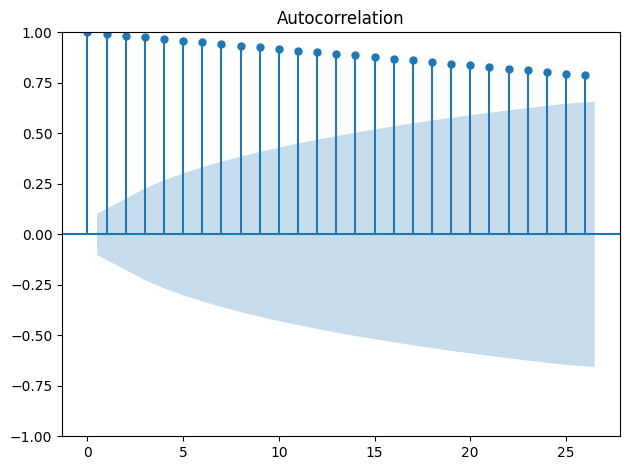

In [50]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['sales'])

plt.tight_layout()

plt.show()

Se puede ver como la tendencia es a perder correlacion.


Con el fin de evitar problemas, voy a eliminar la columna referente a media movil

In [51]:
df.drop(columns=['media_movil'], inplace=True)

## Implementando el modelo (ARIMA da problemas)

Ante la imposibilidad, y con el fin de completar el ejercicio , he usado el modelo de Holt-Winters. 

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


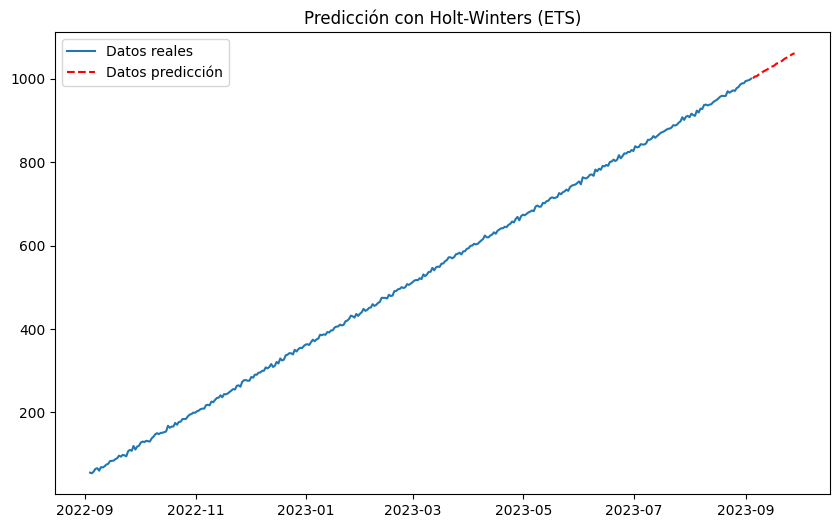

In [72]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

model = ExponentialSmoothing(df['sales'], 
                              trend='add',  
                              seasonal='add', 
                              seasonal_periods=12)  
model_fit = model.fit()

forecast = model_fit.forecast(steps=24)  # He puesto predecir los proximos 24 pasos (2 años)


plt.figure(figsize=(10, 6))
plt.plot(df['sales'], label="Datos reales")  
plt.plot(forecast, label="Datos predicción", linestyle="dashed", color="red")
plt.legend()
plt.title("Predicción con Holt-Winters (ETS)")
plt.show()
